In [1]:
import time
import sys

import matplotlib.pyplot as plt

import folium
sys.path.append('../')
from optimiser import *

In [2]:
address_file_path = '../data/addresses.csv'

In [3]:
target_address = '9 Boulevard Decouz, 74000 Annecy France'

In [4]:
max_pass = 4

In [5]:
employee_data = get_employee_data(address_file_path)
employee_addresses = [emp[2] for emp in employee_data]

# Step by Step processing

## Converting addresses to GPS coordinates

In [6]:
tgt_point = AddressPoint(target_address)

In [7]:
s_time = time.time()
emp_points={}
for emp_address in employee_addresses:
    add_point = AddressPoint(emp_address)
    emp_points[emp_address] = add_point
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 21.36


## Problem visualisation

In [8]:
full_map = folium.Map(location=[tgt_point.latitude, tgt_point.longitude], zoom_start=11)
folium.Marker([tgt_point.latitude, tgt_point.longitude]).add_to(full_map)
for cur_point in emp_points.values():
    folium.Circle(radius = 10, location=[cur_point.latitude, cur_point.longitude], color='red', fill=True).add_to(full_map)
full_map

## Converting GPS (latitude, longitude) to cartesian coordinates

In [9]:
s_time = time.time()
emp_coords = {k: cartesian_coordinates(p, tgt_point, tgt_point.latitude)
                  for k, p in emp_points.items()}
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 0.00


## Cartesian coordinates View
## The coordinates are needed for clustering (k-means) in the next step

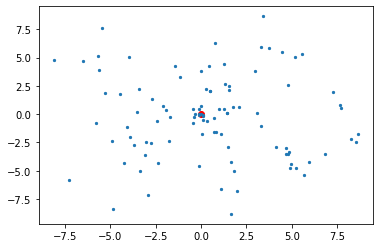

In [10]:
plt.scatter([0], [0], c='red')
plt.scatter([emp[0] for emp in emp_coords.values()], [emp[1] for emp in emp_coords.values()], s=5)

## Using k-means algorithm to create clusters of maximum size 4 (number of passengers)

In [11]:
s_time = time.time()
init_groups = group_employees(emp_coords, max_pass)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 0.37


## Optimising each cluster (check for optimal additional split, calculate optimal path)

In [12]:
s_time = time.time()
fin_groups = []
for g in init_groups:
    fin_groups += await optimise_group_async(g, emp_points, tgt_point)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 51.68


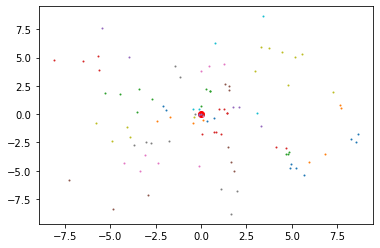

In [13]:
plt.scatter([0], [0], c='red')
for g in fin_groups:
    plt.scatter([emp_coords[add][0] for add in g[0]], [emp_coords[add][1] for add in g[0]], s=1)

## Retrieving Results

In [14]:
p_count = 1
for res in fin_groups:
    print('group {}'.format(p_count))
    print('group addresses: {}'.format(res[0]))
    print('individual paths distances: \t{:.1f}'.format(res[1]))
    print('optimised path distances: \t{:.1f}'.format(res[2]))
    print('Distance gain: \t\t\t{:.1f} \n'.format(res[1]-res[2]))
    p_count += 1

group 1
group addresses: ['1 Route du Crêt des Vignes,  74290', '1 Plage du Plan,  74290', '1 Chemin du Roc de Chère,  74290', "1 Promenade Philibert d'Orlye,  74290"]
individual paths distances: 	39.0
optimised path distances: 	12.1
Distance gain: 			26.9 

group 2
group addresses: ['1 Menthon-Saint-Bernard,  74290', '1 Chemin des Penoz,  74290']
individual paths distances: 	20.8
optimised path distances: 	11.1
Distance gain: 			9.7 

group 3
group addresses: ['1 Route de Morat,  74290', '1 Route de Thônes,  74290', '1 Chabloux,  74290']
individual paths distances: 	24.6
optimised path distances: 	8.8
Distance gain: 			15.8 

group 4
group addresses: ['1 Plage de La Brune,  74290', '1 Les Mottes,  74290']
individual paths distances: 	14.8
optimised path distances: 	8.3
Distance gain: 			6.5 

group 5
group addresses: ['10 Chemin de la Maveria, 74000 Veyrier-du-Lac']
individual paths distances: 	5.0
optimised path distances: 	5.0
Distance gain: 			0.0 

group 6
group addresses: ["408 R

## Global results

In [15]:
individual_dist = sum([g[1] for g in fin_groups])
carpool_dist = sum([g[2] for g in fin_groups])
print('Total individual distances: \t {:.1f} km'.format(individual_dist))
print('Total carpooling distances: \t {:.1f} km'.format(carpool_dist))
print('Distance saved (km): \t\t {:.1f} km'.format(individual_dist - carpool_dist))

Total individual distances: 	 636.5 km
Total carpooling distances: 	 307.1 km
Distance saved (km): 		 329.4 km


## Group focus

In [16]:
pos = 10
g = fin_groups[pos]
full_map = folium.Map(location=[tgt_point.latitude, tgt_point.longitude], zoom_start=11, width='50%', height='50%')
folium.Marker([tgt_point.latitude, tgt_point.longitude]).add_to(full_map)
for cur_point in g[0]:
    folium.Circle(radius = 10, location=[emp_points[cur_point].latitude, emp_points[cur_point].longitude], color='red', fill=True).add_to(full_map)

print('Group addresses:')
for el in g[0]:
    print('address: {}'.format(el))
print('\nTotal individual distances: \t{:.2f}'.format(g[1]))
print('Carpooling distance: \t\t{:.2f}'.format(g[2]))
print('Distance saved (km): \t\t{:.2f}\n'.format(g[1]-g[2]))
full_map

Group addresses:
address: 186 Route des Villards, 74290 Alex
address: 1 Chemin du Crêt du Faux,  74290
address: 1 Chemin de Chantapot,  74290

Total individual distances: 	40.97
Carpooling distance: 		15.52
Distance saved (km): 		25.45

